# One Dimensional Example: Inversion/Assimilation & OED

In [1]:
# Import simulation model, observation oeprator, error (prior and observation noise) model, and DA
from pyoed.models.simulation_models.toy_linear import ToyLinearTimeDependent
from pyoed.models.observation_operators.identity import Identity
from pyoed.models.error_models.Gaussian import GaussianErrorModel
from pyoed.assimilation.smoothing.fourDVar import VanillaFourDVar

## Assimilation (Bayesian Inversion)

### Create the inverser problem

In [2]:
# Create the simulation model
model = ToyLinearTimeDependent(configs={'nx':5, 'dt':0.1, 'random_seed':123})
print(f"Model array:\n{model.get_model_array()}")

# Create observation operator
obs_oper = Identity(configs={'model':model})

# Create prior and observation error model
prior = GaussianErrorModel(configs={'size':model.state_size, 'mean':0, 'variance':1, 'random_seed':1})
obs_noise = GaussianErrorModel(configs={'size':obs_oper.shape[0], 'variance':0.001, 'random_seed':1})

# Inverse Problem 4DVar DA object, and register its elements
inverse_problem = VanillaFourDVar()
inverse_problem.register_model(model)
inverse_problem.register_observation_operator(obs_oper)
inverse_problem.register_prior_model(prior)
inverse_problem.register_observation_error_model(obs_noise)

Model array:
[[-0.99 -0.37  1.29  0.19  0.92]
 [ 0.58 -0.64  0.54 -0.32 -0.32]
 [ 0.1  -1.53  1.19 -0.67  1.  ]
 [ 0.14  1.53 -0.66 -0.31  0.34]
 [-2.21  0.83  1.54  1.13  0.75]]


### Create and register synthetic obserations/Data

In [3]:
# Set the assimilation/simulation time window
tspan = (0, 0.3)
inverse_problem.register_assimilation_window(tspan)

# Create truth (true initial state and trajectory)
true_IC = model.create_initial_condition()
print(true_IC)
checkpoints = [0.1, 0.2, 0.3]
_, true_traject = model.integrate_state(true_IC, tspan=tspan, checkpoints=checkpoints)

# Create synthetic data (perturbation to truth) and register them
for t, state in zip(checkpoints, true_traject):
    obs = obs_noise.add_noise(obs_oper(state))
    inverse_problem.register_observation(t=t, observation=obs)

[-0.36176687 -1.2302322   1.22622929 -2.17204389 -0.37014735]


### Solve the inverse problem

In [4]:
# Solve the inverse problem (retrieve the truth)
inverse_problem.solve_inverse_problem(init_guess=prior.mean.copy(), update_posterior=True)

array([-0.11039567, -1.20251881,  1.27913471, -1.86907931, -0.20786296])

In [5]:
# Statistics
from pyoed import utility
prior_rmse = utility.calculate_rmse(true_IC, inverse_problem.prior.mean)
posterior_rmse = utility.calculate_rmse(true_IC, inverse_problem.posterior.mean)
print(f"Prior RMSE: {prior_rmse}")
print(f"Posterrior RMSE: {posterior_rmse}")

Prior RMSE: 1.2651299147925466
Posterrior RMSE: 0.1922905370290526


In [6]:
# Calculate prior and posterior trajectory and evaluate RMSE
checkpoints, true_traject = model.integrate_state(true_IC, tspan=tspan)
_, prior_traject = model.integrate_state(inverse_problem.prior.mean, tspan=tspan)
_, posterior_traject = model.integrate_state(inverse_problem.posterior.mean, tspan=tspan)
prior_rmse = [utility.calculate_rmse(xp, xt) for xp, xt in zip(prior_traject, true_traject)]
posterior_rmse = [utility.calculate_rmse(xp, xt) for xp, xt in zip(posterior_traject, true_traject)]

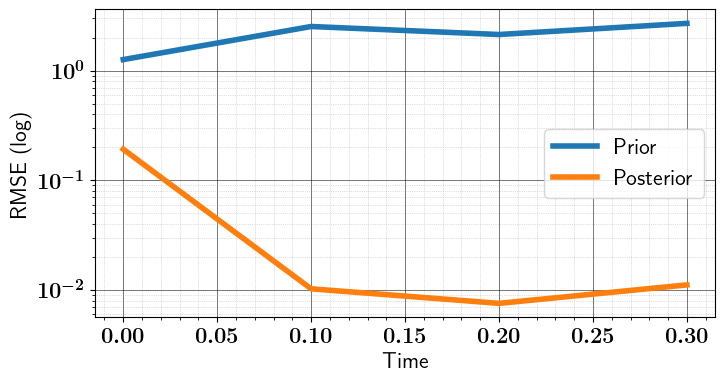

In [7]:
import matplotlib.pyplot as plt
utility.plots_enhancer(usetex=True, fontsize=16)

# Plot RMSE (for prior and posterior/analysis)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
_ = ax.plot(checkpoints, prior_rmse, '-', lw=4, label='Prior')
_ = ax.plot(checkpoints, posterior_rmse, '-', lw=4, label='Posterior')
ax.set_yscale('log')
ax.set_xlabel("Time")
ax.set_ylabel("RMSE (log)")
ax.legend(loc='best')
utility.show_axis_grids(ax)
fig.savefig("ToyLinear4DVar_RMSE.pdf", dpi=600, bbox_inches='tight', transparent=True)

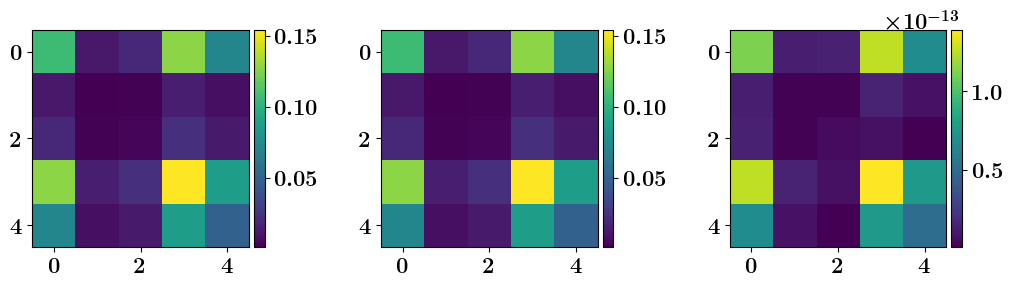

In [8]:
# IP posterrior covariance matrix
import numpy as np
post_cov = inverse_problem.posterior.covariance_matrix()

# Exact (from R, B, F)
F = model.get_model_array()
Rinv = obs_noise.precision_matrix()
Binv = prior.precision_matrix()
A = np.zeros_like(Binv)
for i in range(1, 4):
    M = np.linalg.matrix_power(F, i)
    A += np.dot(M.T, np.dot(Rinv, M))
A = np.linalg.inv(Binv +  A)
Aerr = np.abs(post_cov - A)  # Error/mismatch

# Plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

im = axes[0].imshow(post_cov)
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, orientation='vertical', cax=cax)

im = axes[1].imshow(A)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, orientation='vertical', cax=cax)

im = axes[2].imshow(Aerr)
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, orientation='vertical', cax=cax)

# Adjust space between subplots
plt.subplots_adjust(wspace=1.25, hspace=0.25,)
plt.subplots_adjust(wspace=0.50, hspace=0.25,)

fig.savefig("ToyLinear4DVar_PostCov.pdf", dpi=600, bbox_inches='tight', transparent=True)

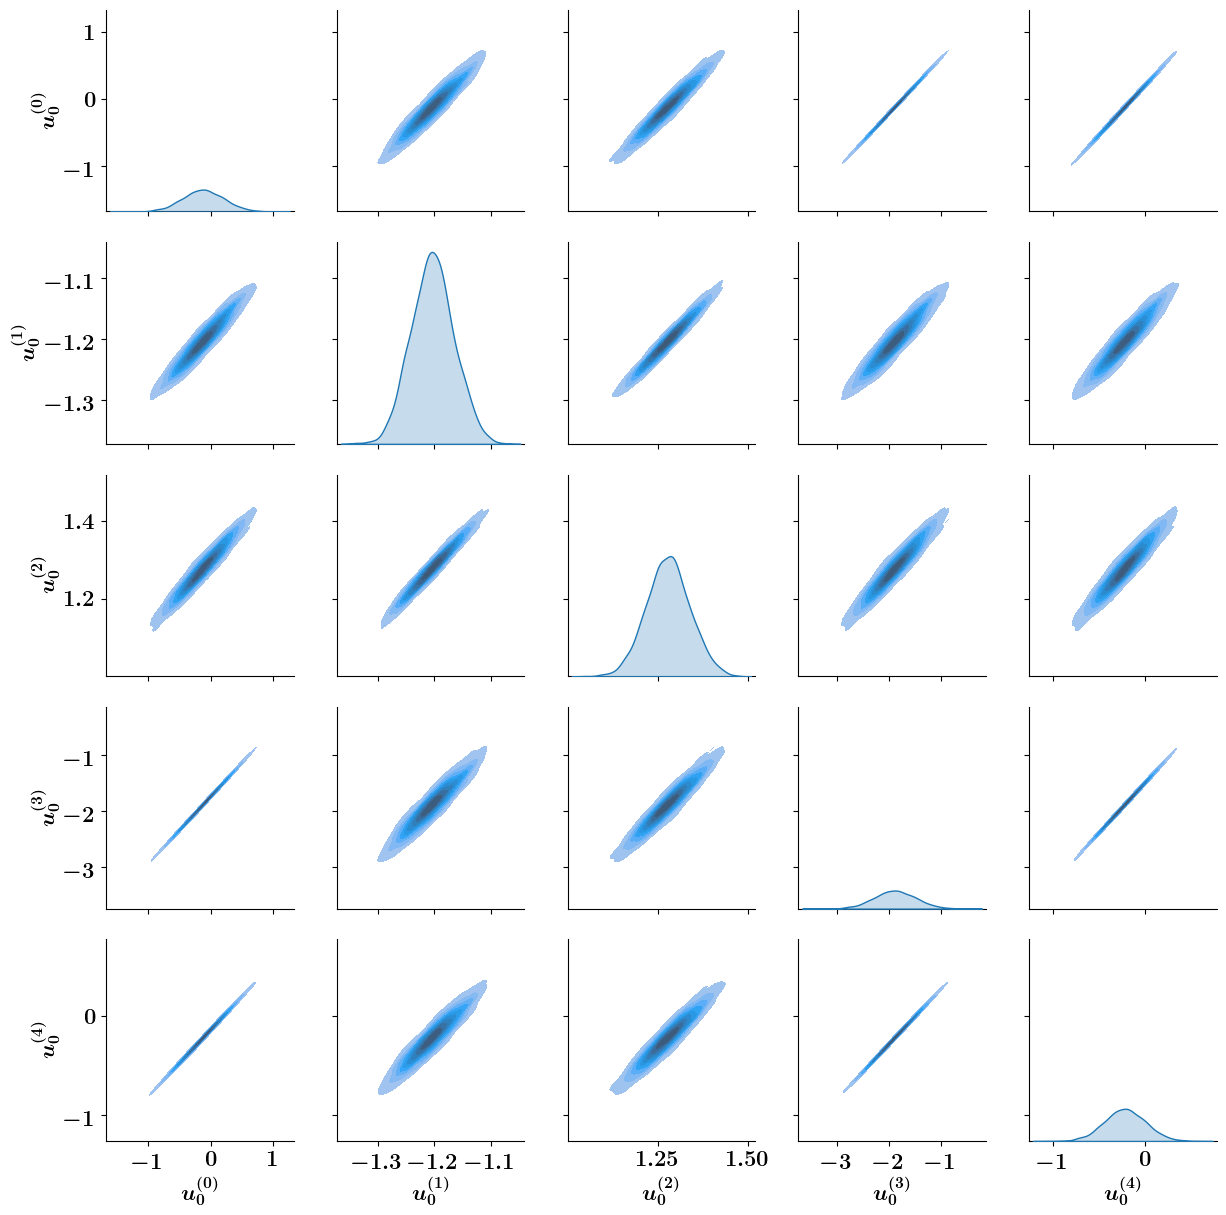

In [9]:
import seaborn as sns
import pandas as pd
N_samples = 2000
samples = pd.DataFrame(
    [inverse_problem.posterior.sample() for _ in range(N_samples)], 
    columns=[r"$u_0^{(%d)}$"%i for i in range(5)]
)
g = sns.PairGrid(samples)
g = g.map_diag(sns.kdeplot, fill = True, common_norm=True)
g = g.map_offdiag(sns.kdeplot, fill = True)
g.savefig("ToyLinear4DVar_PairPlot.pdf", dpi=600, bbox_inches='tight', transparent=True)

## Optimal Experimental Design (OED)

### Standard Relaxed OED

/opt/homebrew/Caskroom/miniconda/base/envs/pyoed-dev/lib/python3.12/site-packages/pyoed/oed/sensor_placement/relaxed_oed.py:833: OptimizeWarning: Unknown solver options: verbose
  res = sp_optimize.minimize(


Sensors plots created.


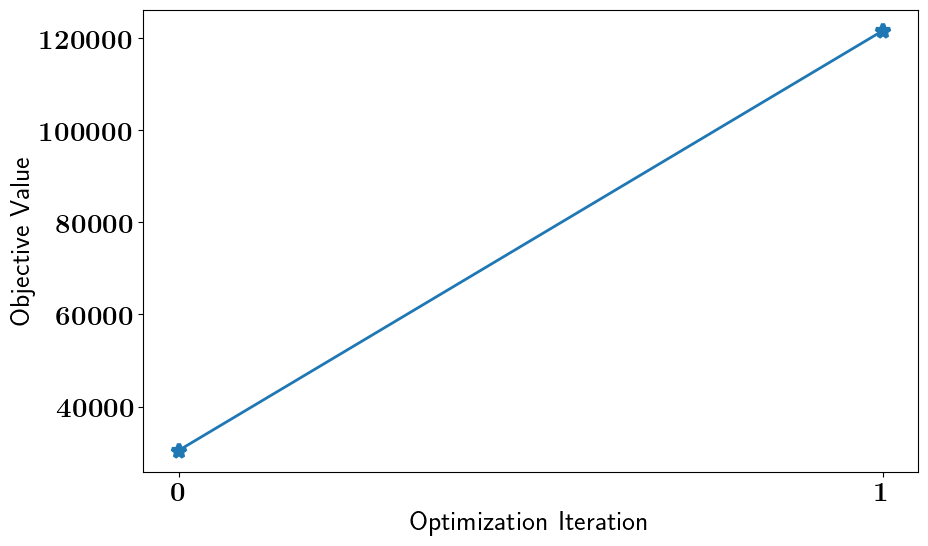

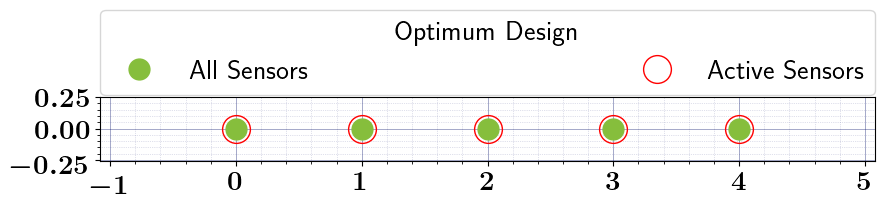

In [10]:
from pyoed.oed.sensor_placement.relaxed_oed import SensorPlacementRelaxedOED
relaxed_oed_problem = SensorPlacementRelaxedOED(
    configs=dict(
        inverse_problem=inverse_problem,
        formulation_approach="pre-post-precision-multiplication",
        criterion='A-opt',
        use_FIM=True,
    )
)
relaxed_oed_results = relaxed_oed_problem.solve_oed_problem()
relaxed_oed_results.plot_results(keep_plots=True, overwrite=True, )

### Pointwise Weighted Relaxed OED

In [11]:
from pyoed.oed.sensor_placement.relaxed_oed import SensorPlacementPointwiseRelaxedOED
pointwise_relaxed_oed_problem = SensorPlacementPointwiseRelaxedOED(
    configs=dict(
        inverse_problem=inverse_problem, 
        criterion='D-opt',
        use_FIM=True
    )
)

In [12]:
budget = 2
penalty_f_l2 = lambda design: np.power(np.sum(design)-budget, 2)
penalty_f_l2_grad = lambda design: 2 * (np.sum(design)-budget) * np.ones_like(design)
pointwise_relaxed_oed_problem.register_penalty_term(
    penalty_weight=-1,
    penalty_function=penalty_f_l2,
    penalty_function_gradient=penalty_f_l2_grad,    
)

Sensors plots created.


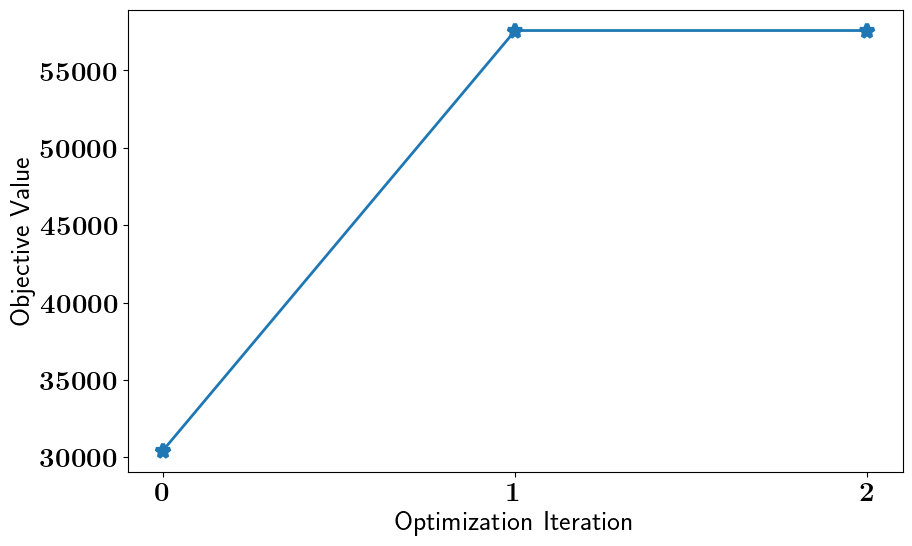

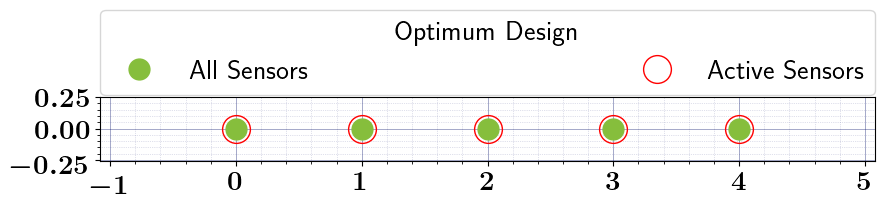

In [13]:
pointwise_relaxed_oed_results = pointwise_relaxed_oed_problem.solve_oed_problem()
pointwise_relaxed_oed_results.plot_results(keep_plots=True, overwrite=True, )

### Stochastic Binary OED

REINFORCE Iteration: 1 ; Step-Update-Norm: 1.118033988749895 
REINFORCE Iteration: 2 ; Step-Update-Norm: 0.0 
Sensors plots created.
Sensors plots created.
Sensors plots created.
Sensors plots created.
Sensors plots created.
Sensors plots created.
Sensors plots created.
Plots saved...
[ True  True  True  True  True]
[1. 1. 1. 1. 1.]


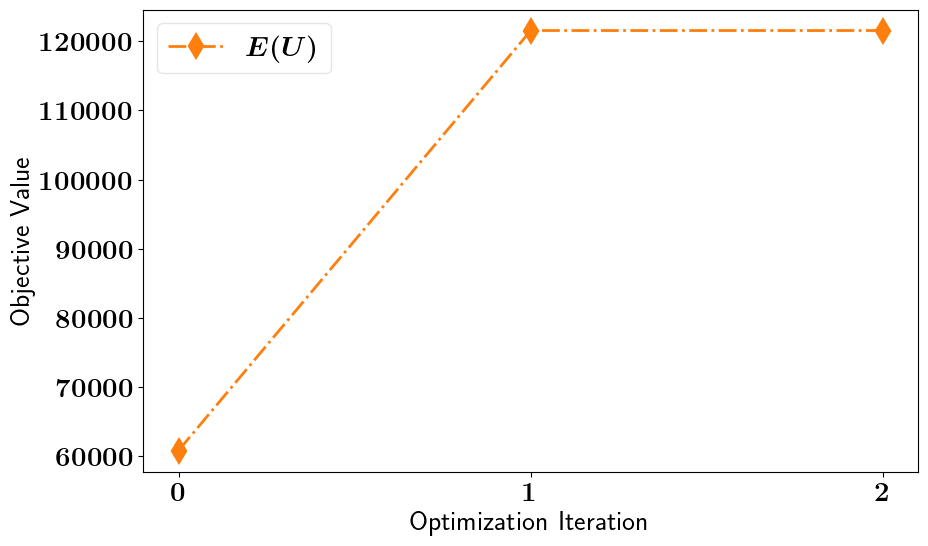

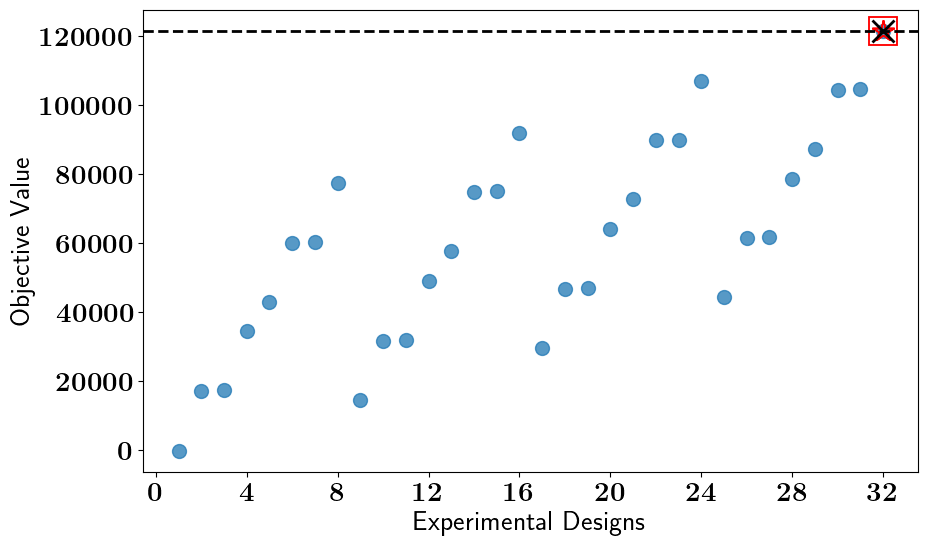

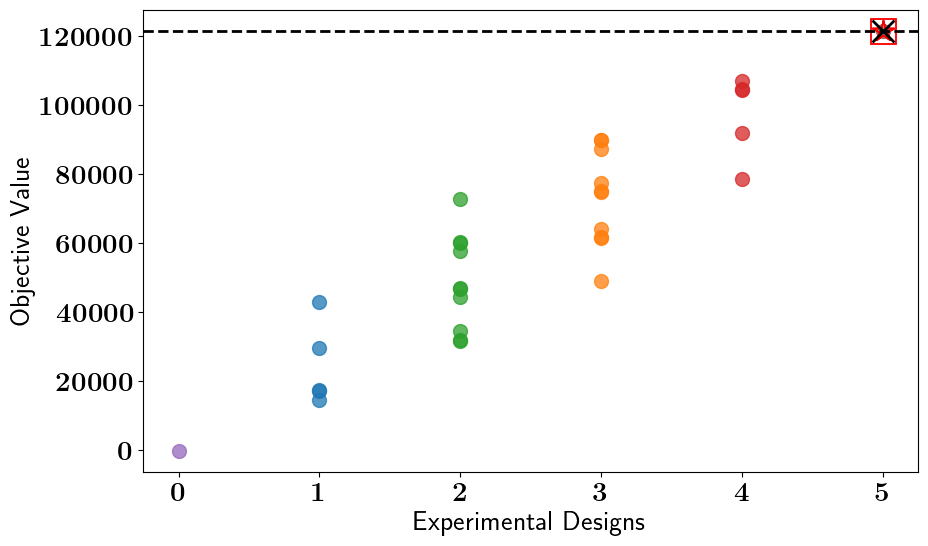

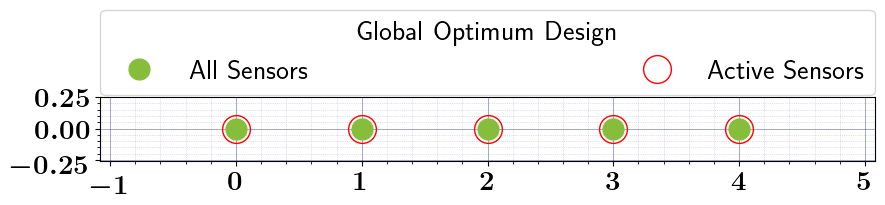

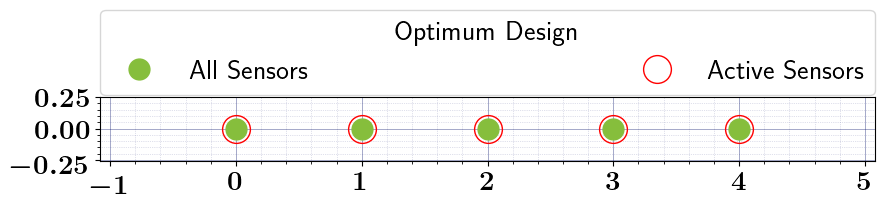

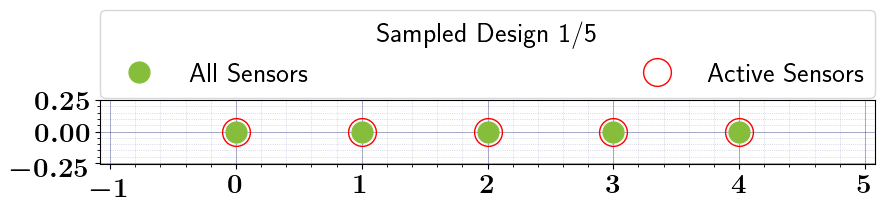

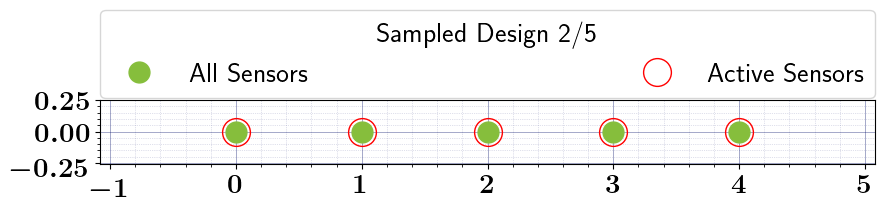

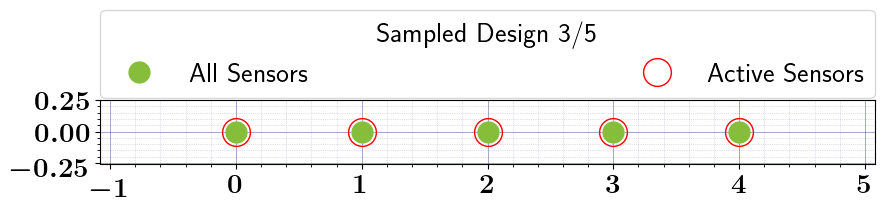

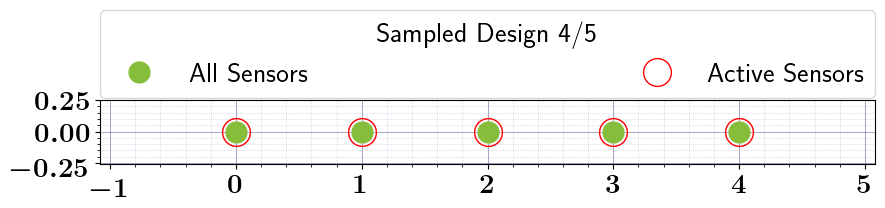

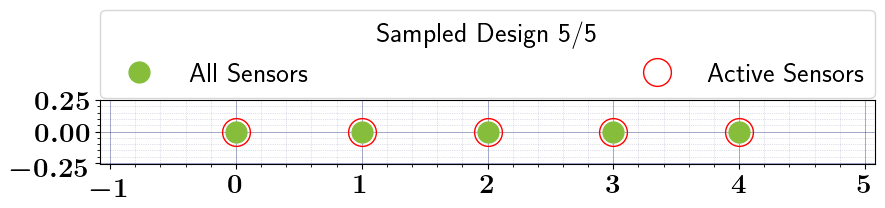

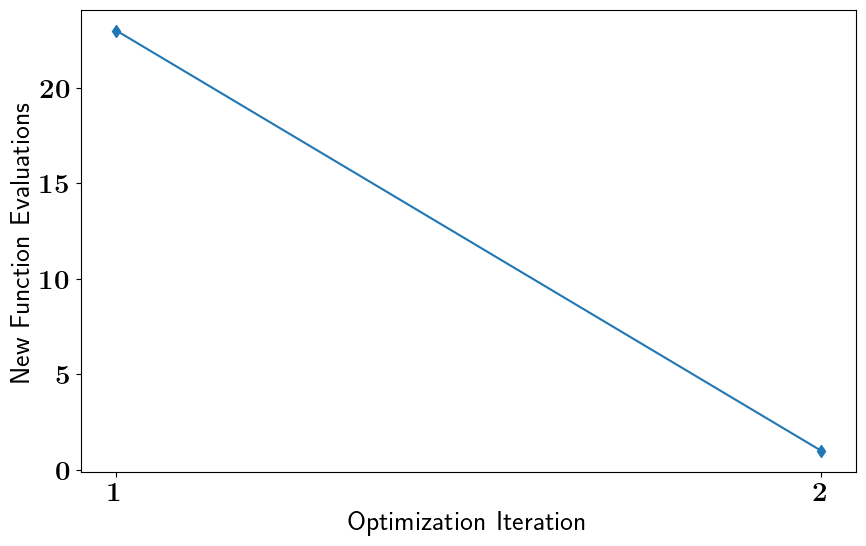

In [14]:
from pyoed.oed.sensor_placement.binary_oed import SensorPlacementBinaryOED

stochastic_oed_problem = SensorPlacementBinaryOED(
    configs=dict(
        inverse_problem=inverse_problem,
        criterion='D-opt',
        use_FIM=True,
        optimization_settings=dict(
            def_stepsize=7.5e-2,
            random_seed=1011,
            max_iter=100,
        )
    )
)

# Add a penalty term
budget = 2
# penalty_f_l2 = lambda design: abs(np.count_nonzero(design)-budget)
penalty_f_l2 = lambda design: np.power(np.sum(design)-budget, 2)
stochastic_oed_problem.register_penalty_term(
    penalty_weight=-20,
    penalty_function=penalty_f_l2,
)

# Solve the OED problem, Run Bruteforce search, and plot results
stochastic_oed_results = stochastic_oed_problem.solve_oed_problem()
stochastic_oed_results.update_bruteforce_results()
stochastic_oed_results.plot_results(overwrite=True, keep_plots=True, )
print(stochastic_oed_results.optimal_design)
print(stochastic_oed_results.optimal_policy_parameter)